In [1]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = 'fruits_dataset'
classes = os.listdir(data_dir)

In [3]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 9124


In [5]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [6]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Avocado (2)


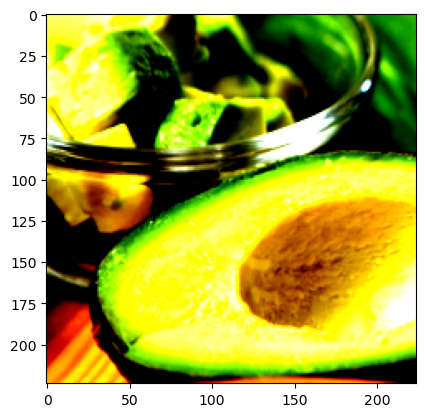

In [7]:
show_image(*dataset[200])

In [8]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [9]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(7756, 456, 912)

In [10]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


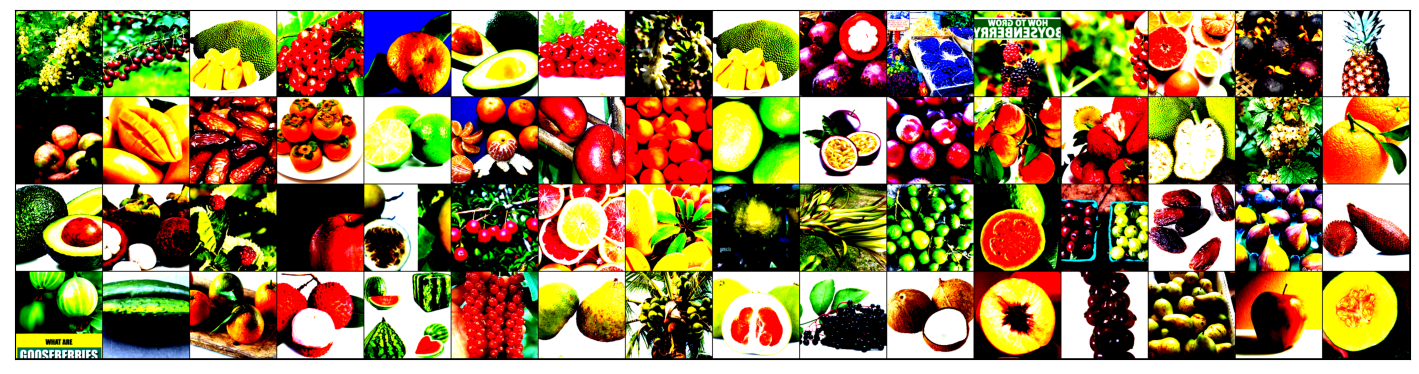

In [11]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [12]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
input_size = 3*224*224
output_size = 55

In [16]:
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
# Convolutional Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.conv11 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
        )
        self.conv12 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        self.conv13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        # Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 3 * 3, 4096),
            nn.Dropout(0.5),  # Dropout Layer
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.Dropout(0.4),  # Dropout Layer
        )
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 120),
            nn.Dropout(0.5),  # Dropout Layer
        )
        self.fc4 = nn.Sequential(
            nn.Linear(120, self.num_classes),
            nn.Dropout(0.4),  # Dropout Layer
        )
        
    def forward(self, x):
        x = self.pool(self.conv3(self.conv2(self.conv1(x))))
        x = self.pool(self.conv5(self.conv4(x)))
        x = self.pool(self.conv7(self.conv6(x)))
        x = self.pool(self.conv10(self.conv9(self.conv8(x))))
        x = self.pool(self.conv11(x))
        x = self.pool(self.conv13(self.conv12(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x


In [17]:
# Model print
num_classes = 55
model = ConvolutionalNetwork(num_classes)
#model.cuda()

In [18]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 224, 224])
out.shape: torch.Size([64, 55])
out[0]: tensor([0.0157, 0.0057, 0.0157, 0.0157, 0.0157, 0.0145, 0.0157, 0.0459, 0.0118,
        0.0302, 0.0101, 0.0085, 0.0157, 0.0157, 0.0284, 0.0157, 0.0078, 0.0157,
        0.0157, 0.0136, 0.0157, 0.0213, 0.0157, 0.0157, 0.0036, 0.0157, 0.0327,
        0.0157, 0.0157, 0.0240, 0.0130, 0.0157, 0.0156, 0.0356, 0.0157, 0.0389,
        0.0157, 0.0136, 0.0157, 0.0472, 0.0095, 0.0157, 0.0140, 0.0039, 0.0307,
        0.0220, 0.0355, 0.0157, 0.0157, 0.0157, 0.0157, 0.0204, 0.0157, 0.0073,
        0.0262], grad_fn=<SelectBackward0>)


In [19]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5),

In [20]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_drop_period, gamma=lr_drop_factor)
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        scheduler.step()  # Adjust learning rate
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [21]:
model = to_device(model, device)

In [22]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 4.007293224334717, 'val_acc': 0.0546875}]

In [23]:
print(test_size)
num_epochs = 110
optimizer = torch.optim.SGD
momentum = 0.90
lr = 0.01
lr_drop_period = 50
lr_drop_factor = 0.2
epochs = 110
l2_reg = 0.0005

912


In [24]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, optimizer)

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.0073, val_loss: 4.0069, val_acc: 0.0703


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.0064, val_loss: 4.0057, val_acc: 0.0664


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.0018, val_loss: 3.9993, val_acc: 0.0605


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.9972, val_loss: 3.9863, val_acc: 0.0840


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.9930, val_loss: 3.9843, val_acc: 0.0957


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.9905, val_loss: 3.9825, val_acc: 0.1094


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.9906, val_loss: 3.9816, val_acc: 0.1133


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.9896, val_loss: 3.9851, val_acc: 0.1270


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.9886, val_loss: 3.9831, val_acc: 0.1133


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.9866, val_loss: 3.9804, val_acc: 0.1191


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.9864, val_loss: 3.9788, val_acc: 0.1309


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.9861, val_loss: 3.9857, val_acc: 0.1348


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [12], train_loss: 3.9816, val_loss: 3.9780, val_acc: 0.1270


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [13], train_loss: 3.9773, val_loss: 3.9749, val_acc: 0.1250


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [14], train_loss: 3.9775, val_loss: 3.9686, val_acc: 0.1445


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [15], train_loss: 3.9740, val_loss: 3.9726, val_acc: 0.1328


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [16], train_loss: 3.9722, val_loss: 3.9697, val_acc: 0.1367


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [17], train_loss: 3.9720, val_loss: 3.9664, val_acc: 0.1387


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [18], train_loss: 3.9696, val_loss: 3.9631, val_acc: 0.1484


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [19], train_loss: 3.9683, val_loss: 3.9613, val_acc: 0.1504


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [20], train_loss: 3.9633, val_loss: 3.9540, val_acc: 0.1621


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [21], train_loss: 3.9637, val_loss: 3.9564, val_acc: 0.1719


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [22], train_loss: 3.9615, val_loss: 3.9625, val_acc: 0.1582


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [23], train_loss: 3.9528, val_loss: 3.9769, val_acc: 0.1484


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [24], train_loss: 3.9564, val_loss: 3.9501, val_acc: 0.1719


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [25], train_loss: 3.9550, val_loss: 3.9427, val_acc: 0.1758


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [26], train_loss: 3.9539, val_loss: 3.9428, val_acc: 0.1836


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [27], train_loss: 3.9473, val_loss: 3.9461, val_acc: 0.1738


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [28], train_loss: 3.9462, val_loss: 3.9389, val_acc: 0.1855


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [29], train_loss: 3.9409, val_loss: 3.9292, val_acc: 0.2129


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [30], train_loss: 3.9412, val_loss: 3.9363, val_acc: 0.1992


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [31], train_loss: 3.9426, val_loss: 3.9361, val_acc: 0.1875


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [32], train_loss: 3.9399, val_loss: 3.9399, val_acc: 0.2012


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [33], train_loss: 3.9387, val_loss: 3.9367, val_acc: 0.2148


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [34], train_loss: 3.9331, val_loss: 3.9269, val_acc: 0.2500


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [35], train_loss: 3.9343, val_loss: 3.9126, val_acc: 0.2520


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [36], train_loss: 3.9302, val_loss: 3.9141, val_acc: 0.2461


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [37], train_loss: 3.9300, val_loss: 3.9338, val_acc: 0.2227


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [38], train_loss: 3.9243, val_loss: 3.9240, val_acc: 0.2422


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [39], train_loss: 3.9187, val_loss: 3.9120, val_acc: 0.2461


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [40], train_loss: 3.9142, val_loss: 3.8924, val_acc: 0.2676


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [41], train_loss: 3.9151, val_loss: 3.9030, val_acc: 0.2773


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [42], train_loss: 3.9150, val_loss: 3.9526, val_acc: 0.1953


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [43], train_loss: 3.9217, val_loss: 3.8921, val_acc: 0.2715


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [44], train_loss: 3.9099, val_loss: 3.8958, val_acc: 0.2930


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [45], train_loss: 3.9083, val_loss: 3.8953, val_acc: 0.2832


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [46], train_loss: 3.9076, val_loss: 3.8812, val_acc: 0.3105


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [47], train_loss: 3.8975, val_loss: 3.8844, val_acc: 0.3086


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [48], train_loss: 3.9005, val_loss: 3.9067, val_acc: 0.2363


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [49], train_loss: 3.8989, val_loss: 3.8801, val_acc: 0.2832


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [50], train_loss: 3.8825, val_loss: 3.8602, val_acc: 0.3398


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [51], train_loss: 3.8839, val_loss: 3.8606, val_acc: 0.3184


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [52], train_loss: 3.8799, val_loss: 3.8570, val_acc: 0.3223


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [53], train_loss: 3.8788, val_loss: 3.8531, val_acc: 0.3184


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [54], train_loss: 3.8798, val_loss: 3.8484, val_acc: 0.3496


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [55], train_loss: 3.8790, val_loss: 3.8485, val_acc: 0.3164


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [56], train_loss: 3.8798, val_loss: 3.8394, val_acc: 0.3223


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [57], train_loss: 3.8803, val_loss: 3.8449, val_acc: 0.3184


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [58], train_loss: 3.8756, val_loss: 3.8452, val_acc: 0.3301


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [59], train_loss: 3.8745, val_loss: 3.8495, val_acc: 0.3516


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [60], train_loss: 3.8766, val_loss: 3.8440, val_acc: 0.3457


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [61], train_loss: 3.8737, val_loss: 3.8461, val_acc: 0.3438


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [62], train_loss: 3.8811, val_loss: 3.8441, val_acc: 0.3516


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [63], train_loss: 3.8748, val_loss: 3.8403, val_acc: 0.3555


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [64], train_loss: 3.8778, val_loss: 3.8432, val_acc: 0.3340


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [65], train_loss: 3.8751, val_loss: 3.8386, val_acc: 0.3340


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [66], train_loss: 3.8731, val_loss: 3.8472, val_acc: 0.3438


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [67], train_loss: 3.8734, val_loss: 3.8495, val_acc: 0.3496


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [68], train_loss: 3.8719, val_loss: 3.8415, val_acc: 0.3438


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [69], train_loss: 3.8729, val_loss: 3.8433, val_acc: 0.3203


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [70], train_loss: 3.8694, val_loss: 3.8401, val_acc: 0.3457


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [71], train_loss: 3.8695, val_loss: 3.8464, val_acc: 0.3418


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [72], train_loss: 3.8721, val_loss: 3.8419, val_acc: 0.3652


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [73], train_loss: 3.8680, val_loss: 3.8420, val_acc: 0.3477


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [74], train_loss: 3.8717, val_loss: 3.8481, val_acc: 0.3457


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [75], train_loss: 3.8673, val_loss: 3.8373, val_acc: 0.3477


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [76], train_loss: 3.8633, val_loss: 3.8374, val_acc: 0.3535


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [77], train_loss: 3.8625, val_loss: 3.8368, val_acc: 0.3359


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [78], train_loss: 3.8654, val_loss: 3.8311, val_acc: 0.3457


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [79], train_loss: 3.8605, val_loss: 3.8282, val_acc: 0.3613


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [80], train_loss: 3.8642, val_loss: 3.8380, val_acc: 0.3652


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [81], train_loss: 3.8699, val_loss: 3.8457, val_acc: 0.3281


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [82], train_loss: 3.8613, val_loss: 3.8273, val_acc: 0.3574


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [83], train_loss: 3.8601, val_loss: 3.8343, val_acc: 0.3516


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [84], train_loss: 3.8582, val_loss: 3.8257, val_acc: 0.3652


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [85], train_loss: 3.8592, val_loss: 3.8357, val_acc: 0.3438


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [86], train_loss: 3.8636, val_loss: 3.8320, val_acc: 0.3555


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [87], train_loss: 3.8632, val_loss: 3.8713, val_acc: 0.3203


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [88], train_loss: 3.8608, val_loss: 3.8193, val_acc: 0.3613


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [89], train_loss: 3.8613, val_loss: 3.8239, val_acc: 0.3574


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [90], train_loss: 3.8548, val_loss: 3.8251, val_acc: 0.3672


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [91], train_loss: 3.8531, val_loss: 3.8276, val_acc: 0.3535


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [92], train_loss: 3.8576, val_loss: 3.8347, val_acc: 0.3730


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [93], train_loss: 3.8579, val_loss: 3.8166, val_acc: 0.3887


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [94], train_loss: 3.8552, val_loss: 3.8611, val_acc: 0.3477


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [95], train_loss: 3.8494, val_loss: 3.8256, val_acc: 0.3594


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [96], train_loss: 3.8539, val_loss: 3.8234, val_acc: 0.3828


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [97], train_loss: 3.8517, val_loss: 3.8278, val_acc: 0.3672


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [98], train_loss: 3.8518, val_loss: 3.8225, val_acc: 0.3770


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [99], train_loss: 3.8424, val_loss: 3.8504, val_acc: 0.3535


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [100], train_loss: 3.8463, val_loss: 3.8217, val_acc: 0.3828


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [101], train_loss: 3.8471, val_loss: 3.8219, val_acc: 0.3711


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [102], train_loss: 3.8450, val_loss: 3.8210, val_acc: 0.3750


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [103], train_loss: 3.8429, val_loss: 3.8214, val_acc: 0.3750


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [104], train_loss: 3.8362, val_loss: 3.8213, val_acc: 0.4082


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [105], train_loss: 3.8439, val_loss: 3.8200, val_acc: 0.3926


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [106], train_loss: 3.8426, val_loss: 3.8177, val_acc: 0.3965


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [107], train_loss: 3.8402, val_loss: 3.8177, val_acc: 0.3965


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [108], train_loss: 3.8423, val_loss: 3.8206, val_acc: 0.3613


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [109], train_loss: 3.8399, val_loss: 3.8211, val_acc: 0.3867


In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

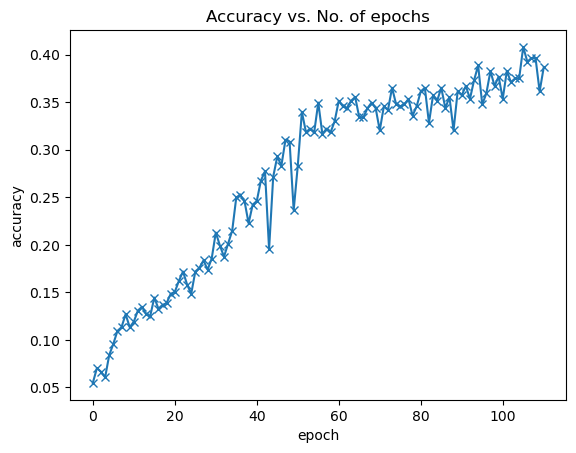

In [26]:
plot_accuracies(history)

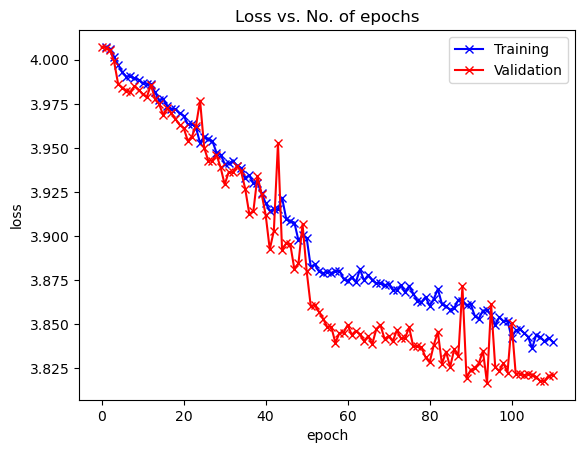

In [27]:
plot_losses(history)

In [28]:
evaluate(model, test_loader)

{'val_loss': 3.7832112312316895, 'val_acc': 0.4385416805744171}

In [29]:
torch.save(model, 'entire_model.pth')

Getting predictions from test set...


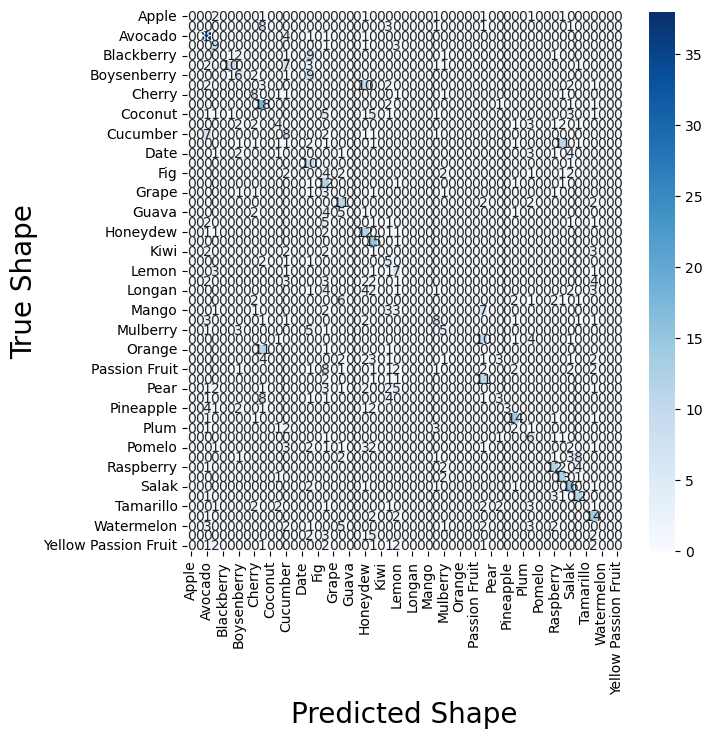

In [30]:
# Defining Labels and Predictions
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns


import pandas as pd
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()